# Kandinsky Patterns

## Lab 1

Tymoteusz Barciński, Agata Kaczmarek, Mateusz Stączek

### Problem selection

Inspired by an original [article](https://www.sciencedirect.com/science/article/pii/S0004370221000977?via%3Dihub) about Kandinsky Patterns, we decided to focus on one of mentioned there challenges. We chose Challenge 1 and decided to slightly modify questions raised there. In general, an idea behind Kardinski Pattens classification is to have data, that is easily recognized by humans, but can be in some way difficult for machine learning algorithms. Later, the main goal is to find the explanation, why did the model decide to classify a Kandinsky Figure as true, false or counterfactual.

In Challenge 1 true data contain big shapes, that are constructed of smaller shapes. In particular, the ground truth for this data is defined as follows: *"in a Kandinsky Figure small objects are arranged on big shapes that are the same as object shapes, in the big shape of type X, no small object of type X exists. Big square shapes only contain blue and red objects, big triangle shapes only contain yellow and red objects and big circle shapes contain only yellow and blue objects”.*

Example of a true, false and counterfactual data for this ground truth:

![Data Challenge 1](/img/all_three.png)

For this project, we decided to focus on choosing a model, which can good classify those data and later on explaining the decisions of this model. In this second part, we would like to answer questions such as: 
* which parts of the figures made model decide, in which class the image belongs,
* is it important for the model, that the small figures are of different shape than the bigger one,
* what would happen, if we change small shapes from trianges and circles to stars and hearts, will the model say it is true or flase,
* and what about changing colors?

We will try to answer those questions, using both already known and implemented explainability methods and also our own approaches.



### Modelling - first attempt


### Loading and processing (scaling) data

Link to original code for generating: https://github.com/human-centered-ai-lab/app-kandinsky-pattern-generator

In [ ]:
#ResNet was tried here https://arxiv.org/pdf/2110.09383.pdf as a benchmark, they used ResNet50 and it overfitted. but they did it for another challenge, so maybe it is good to try it here
#however, here we use resnet18, as 50 is training too long

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from  torchvision.datasets import ImageFolder 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from torchvision import models
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
cpu


In [ ]:
transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize([256, 256])])

train_set = ImageFolder('/work/newly_generated_data/shapeonshapes_1k', transform = transform)


In [ ]:
folder = '/work/newly_generated_data/shapeonshapes_1k'

classes = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]
classes = [classes[2], classes[1], classes[0]] 

print(classes)

['counterfactual', 'false', 'true']


In [ ]:
num_classes = 3
batch_size=16

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
import random

train_size=2500
test_size=250
val_size=250

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(train_set,
                                               [train_size, test_size, val_size])
trainloader = torch.utils.data.DataLoader(
     train_dataset, batch_size=batch_size, shuffle=False)

testloader = torch.utils.data.DataLoader(
     test_dataset, batch_size=batch_size, shuffle=False)

valloader = torch.utils.data.DataLoader(
     val_dataset, batch_size=batch_size, shuffle=False)

torch.Size([16, 3, 256, 256])
torch.Size([16])
label: true
label: true
label: false
label: counterfactual
label: counterfactual
label: true
label: counterfactual
label: false
label: counterfactual
label: true
label: true
label: false
label: counterfactual
label: counterfactual
label: true
label: true


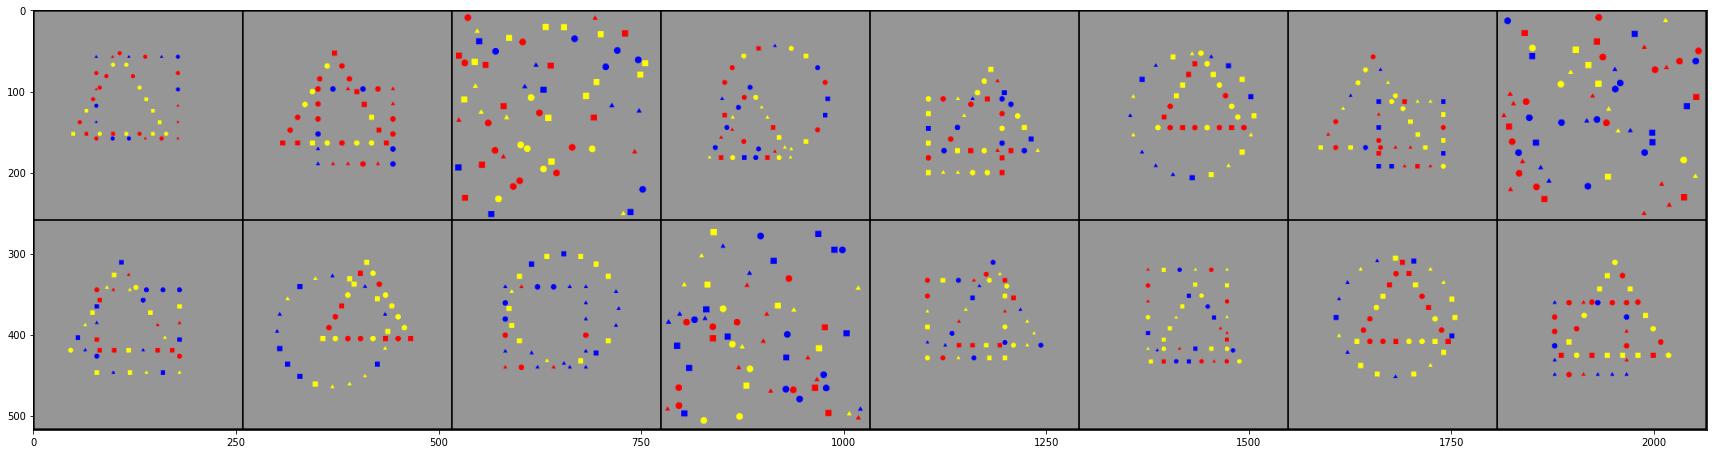

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

grid_testing = torchvision.utils.make_grid(images, nrow=8)

plt.figure(figsize=(30,30))
plt.imshow(grid_testing.permute(1,2,0))

for i in range(batch_size):
    print(f"label: {classes[labels[i]]}")

### Using pretrained ResNet18

In [ ]:
iterations = []
accuracies = []
losses = []

model = torchvision.models.resnet18(pretrained = True)

for param in model.parameters():
    param.required_grad = False

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr = 0.0001)

loss_epoch_arr = []
max_epochs = 1

min_loss = 1000000

n_iters = np.ceil(3000/batch_size)*max_epochs
iters = 0
print(n_iters)

188.0


In [ ]:
for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):
        iters += 1
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if iters % 8 == 0:
            curAccuracy =  evaluation(valloader, model)
            curLoss = loss.item()
            iterations.append(iters)
            accuracies.append(curAccuracy)
            losses.append(curLoss)
            print('Iteration: %d/%d, Loss: %0.2f, Validation acc: %0.2f'%(iters,n_iters, curLoss, curAccuracy))

        del inputs, labels, outputs
        torch.cuda.empty_cache()
    loss_epoch_arr.append(loss.item())
    print('Epoch: %d/%d ended. Validation acc: %0.2f, Train acc: %0.2f' % (
      epoch+1, max_epochs, 
      evaluation(valloader, model), 
      evaluation(trainloader, model)))
    
print('\n\nTest Accuarcy on final model: %0.4f' % evaluation(testloader, model))

Iteration: 8/188, Loss: 0.42, Validation acc: 85.60
Iteration: 16/188, Loss: 0.12, Validation acc: 94.00
Iteration: 24/188, Loss: 0.10, Validation acc: 95.60
Iteration: 32/188, Loss: 0.29, Validation acc: 96.00
Iteration: 40/188, Loss: 0.07, Validation acc: 94.80
Iteration: 48/188, Loss: 0.02, Validation acc: 96.80
Iteration: 56/188, Loss: 0.24, Validation acc: 97.60
Iteration: 64/188, Loss: 0.08, Validation acc: 98.40
Iteration: 72/188, Loss: 0.13, Validation acc: 98.40
Iteration: 80/188, Loss: 0.06, Validation acc: 98.40
Iteration: 88/188, Loss: 0.07, Validation acc: 98.80
Iteration: 96/188, Loss: 0.00, Validation acc: 98.40
Iteration: 104/188, Loss: 0.03, Validation acc: 97.60
Iteration: 112/188, Loss: 0.01, Validation acc: 99.60
Iteration: 120/188, Loss: 0.18, Validation acc: 98.40
Iteration: 128/188, Loss: 0.04, Validation acc: 98.80
Iteration: 136/188, Loss: 0.01, Validation acc: 99.20
Iteration: 144/188, Loss: 0.09, Validation acc: 99.20
Iteration: 152/188, Loss: 0.00, Validatio

In [ ]:
# filename = 'finalized_model10.pth'
# torch.save(model, filename)
loaded_model=torch.load(filename)

Let's check the score on validation set, is it really that high.

In [ ]:
total=0
correct=0
inputs, labels = next(iter(trainloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = loaded_model(inputs)
_, pred = torch.max(outputs.data, 1)
total += labels.size(0)
correct += (pred == labels).sum().item()
print(100 * correct / total)

100.0


torch.Size([16, 3, 256, 256])
tensor([2, 2, 1, 0, 0, 2, 0, 1, 0, 2, 2, 1, 0, 0, 2, 2])
tensor([2, 2, 1, 0, 0, 2, 0, 1, 0, 2, 2, 1, 0, 0, 2, 2])
label: counterfactual, pred: counterfactual
label: counterfactual, pred: counterfactual
label: false, pred: false
label: true, pred: true
label: true, pred: true
label: counterfactual, pred: counterfactual
label: true, pred: true
label: false, pred: false
label: true, pred: true
label: counterfactual, pred: counterfactual
label: counterfactual, pred: counterfactual
label: false, pred: false
label: true, pred: true
label: true, pred: true
label: counterfactual, pred: counterfactual
label: counterfactual, pred: counterfactual


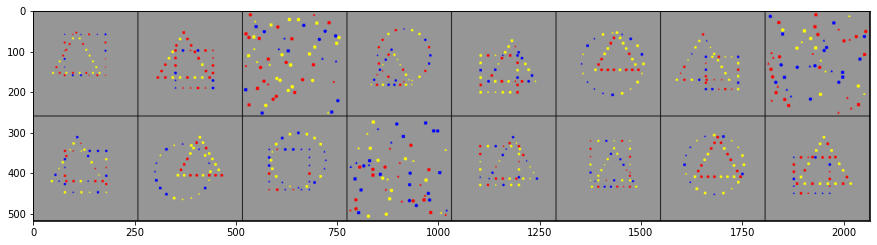

In [ ]:
print(inputs.shape)
print(labels)
print(pred)
grid_testing = torchvision.utils.make_grid(inputs, nrow=8)

plt.figure(figsize=(15,15))
plt.imshow(grid_testing.permute(1,2,0))

for i in range(batch_size):
    print(f"label: {classes[labels[i]]}, pred: {classes[pred[i]]}")

<class 'torch.Tensor'>
true label: true
pred label: true
tensor(2)


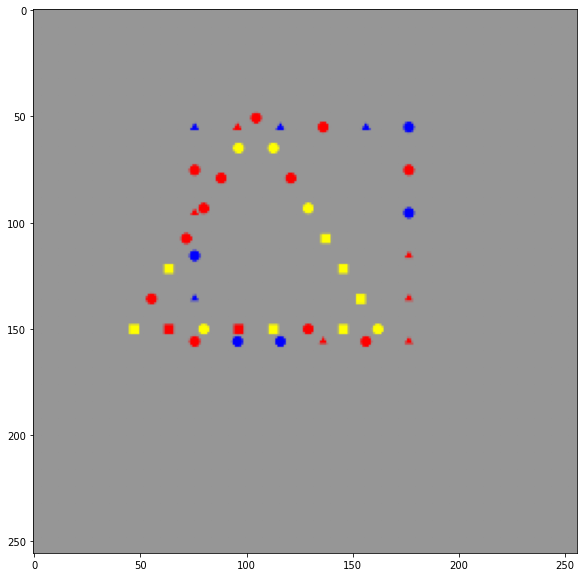

In [ ]:
print(type(inputs[1]))

grid_test = torchvision.utils.make_grid(inputs[0], nrow=10)

plt.figure(figsize=(10,10))
plt.imshow(grid_test.cpu().permute(1,2,0))

print(f'true label: {classes[labels[0]]}')
print(f'pred label: {classes[pred[0]]}')
print(labels[0]) # "2" stands for "true"

## Time for a few explanations

Since accuracy is so high, did this ResNet18 model grasp the theoretical concept (pattern present only in "true" images) in such a way that it can be explained to human beings such as us?

In [ ]:
%%capture
!pip install captum
!pip install scikit-image

In [ ]:
from captum.attr import visualization

def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

Various explanations are presented below, most of them using SHAP method with differing masks and input images.

Kernel Shap attribution: 100%|██████████| 30/30 [00:04<00:00,  6.36it/s]


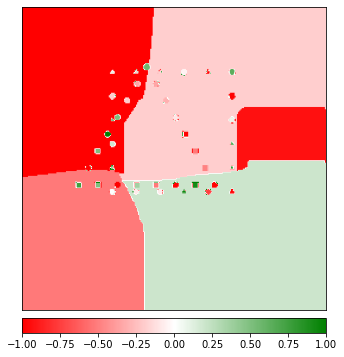

In [ ]:
from captum.attr import KernelShap
from skimage import segmentation
exp_ks_0_2 = KernelShap(loaded_model)

mask_0 = segmentation.quickshift(
    inputs[0].permute(1, 2, 0).double(), 
    kernel_size=25, 
    max_dist=7, 
    ratio=0.7
  )

exp_ks_0_2 = exp_ks_0_2.attribute(
    inputs[0].unsqueeze(0), 
    target=2, 
    n_samples=30, 
    feature_mask=torch.as_tensor(mask_0),
    show_progress=True
  )

show_attr(exp_ks_0_2[0])

Kernel Shap attribution: 100%|██████████| 30/30 [00:04<00:00,  6.27it/s]


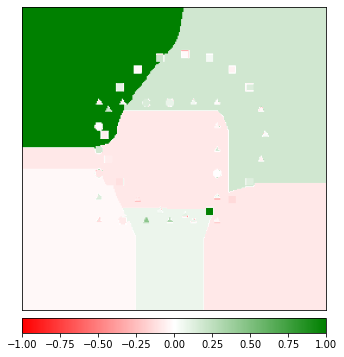

In [ ]:
exp_ks_10_2 = KernelShap(loaded_model)

mask_10 = segmentation.quickshift(
    inputs[10].permute(1, 2, 0).double(), 
    kernel_size=25, 
    max_dist=7, 
    ratio=0.7
  )

exp_ks_10_2 = exp_ks_10_2.attribute(
    inputs[10].unsqueeze(0), 
    target=2, 
    n_samples=30, 
    feature_mask=torch.as_tensor(mask_10),
    show_progress=True
  )

show_attr(exp_ks_10_2[0])

Kernel Shap attribution: 100%|██████████| 30/30 [00:04<00:00,  6.49it/s]


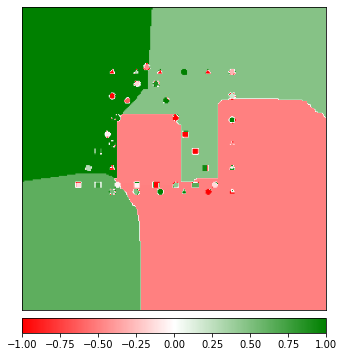

In [ ]:
exp_ks_0_1 = KernelShap(loaded_model)

mask_0_1 = segmentation.quickshift(
    inputs[0].permute(1, 2, 0).double(), 
    kernel_size=20, 
    max_dist=7, 
    ratio=0.7
  )

exp_ks_0_1 = exp_ks_0_1.attribute(
    inputs[0].unsqueeze(0), 
    target=2, 
    n_samples=30, 
    feature_mask=torch.as_tensor(mask_0_1),
    show_progress=True
  )

show_attr(exp_ks_0_1[0])

Kernel Shap attribution: 100%|██████████| 1000/1000 [02:38<00:00,  6.29it/s]


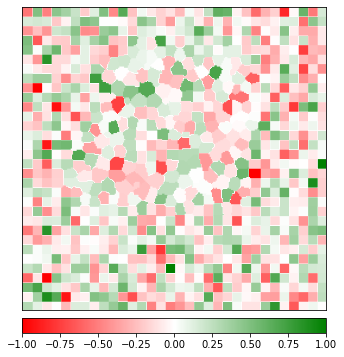

In [ ]:
exp_ks_0_1 = KernelShap(loaded_model)

mask_0_1 = segmentation.slic(
    inputs[0].permute(1, 2, 0).double(), 
    n_segments=1000, 
    compactness=0.8, 
    start_label=0,
    )

exp_ks_0_1 = exp_ks_0_1.attribute(
    inputs[0].unsqueeze(0), 
    target=2, 
    n_samples=1000, 
    feature_mask=torch.as_tensor(mask_0_1),
    show_progress=True
  )

show_attr(exp_ks_0_1[0])

Kernel Shap attribution: 100%|██████████| 30/30 [00:04<00:00,  6.09it/s]


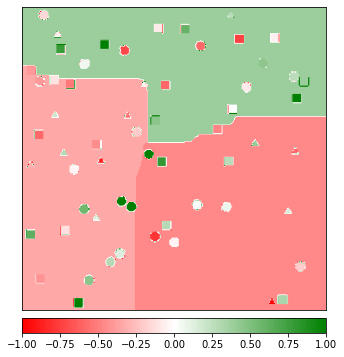

In [ ]:
from captum.attr import KernelShap
from skimage import segmentation
exp_ks_2_2 = KernelShap(loaded_model)

mask_2 = segmentation.quickshift(
    inputs[2].permute(1, 2, 0).double(), 
    kernel_size=25, 
    max_dist=7, 
    ratio=0.7
  )

exp_ks_2_2 = exp_ks_2_2.attribute(
    inputs[2].unsqueeze(0), 
    target=1, 
    n_samples=30, 
    feature_mask=torch.as_tensor(mask_2),
    show_progress=True
  )

show_attr(exp_ks_2_2[0])

Kernel Shap attribution: 100%|██████████| 30/30 [00:05<00:00,  5.39it/s]


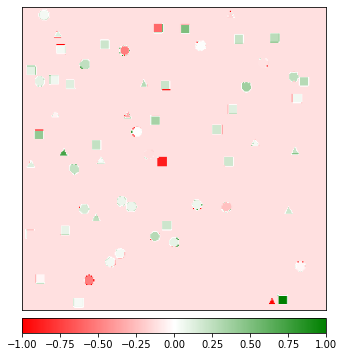

In [ ]:
exp_ks_2_2 = KernelShap(loaded_model)

mask_2 = segmentation.quickshift(
    inputs[2].permute(1, 2, 0).double(), 
    kernel_size=50, 
    max_dist=7, 
    ratio=0.7
  )

exp_ks_2_2 = exp_ks_2_2.attribute(
    inputs[2].unsqueeze(0), 
    target=1, 
    n_samples=30, 
    feature_mask=torch.as_tensor(mask_2),
    show_progress=True
  )

show_attr(exp_ks_2_2[0])

Kernel Shap attribution: 100%|██████████| 30/30 [00:08<00:00,  3.52it/s]


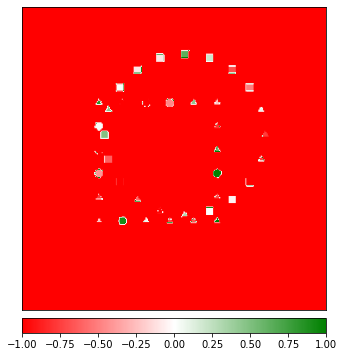

In [ ]:
exp_ks_10_2 = KernelShap(loaded_model)

mask_101 = segmentation.quickshift(
    inputs[10].permute(1, 2, 0).double(), 
    kernel_size=50, 
    max_dist=7, 
    ratio=0.7
  )

exp_ks_10_2 = exp_ks_10_2.attribute(
    inputs[10].unsqueeze(0), 
    target=2, 
    n_samples=30, 
    feature_mask=torch.as_tensor(mask_101),
    show_progress=True
  )

show_attr(exp_ks_10_2[0])

Kernel Shap attribution: 100%|██████████| 30/30 [00:05<00:00,  5.75it/s]


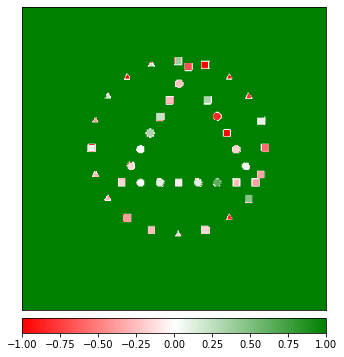

In [ ]:
exp_ks_14_2 = KernelShap(loaded_model)

mask_101 = segmentation.quickshift(
    inputs[14].permute(1, 2, 0).double(), 
    kernel_size=50, 
    max_dist=7, 
    ratio=0.7
  )

exp_ks_14_2 = exp_ks_14_2.attribute(
    inputs[14].unsqueeze(0), 
    target=2, 
    n_samples=30, 
    feature_mask=torch.as_tensor(mask_101),
    show_progress=True
  )

show_attr(exp_ks_14_2[0])

### Summary of attempts

* First, new data was generated using public code from Github. Then, dataloader was created from a pytorch dataset with images resized from default 600x600 to 256x256.

* Having data ready, a pretrained ResNet18 was used and first explanations were created.

* Such a high model accuracy of around 97% was unexpected. We need to investigate it more thoroughly to make sure everything is working as supposed to.

* Explanations using shap values are rather introductory. There doesn’t seem to be an obvious pattern of explanations. Especially the last two are perplexing. Both images belong to the same class but the importance of background is totally different.

## Articles 

### Article 1

Title: **KANDINSKY Patterns as IQ-Test for Machine Learning.**  
Authors: Holzinger et al.   
Publisher: CD-MAKE, 2019.   
Link: [https://link.springer.com/chapter/10.1007/978-3-030-29726-8_1](https://www.aholzinger.at/wordpress/wp-content/uploads/2019/09/Holzinger-Kickmeier-Mueller-KANDINSKY-Patterns-As-IQ-Test-for-AI.pdf)

The main point of this article is to motivate international community of researchers to investigate methods of applying human IQ tests to machine learning models. The history of development as well as various ways to measure intelligence of a person are mentioned and compared to the evaulation of the task-specific AI models (such as Alpha Go specified in the Go game). Although no models are proposed, the *Kandinsky Patterns* dataset is recommended and it's advantages for evaulating *model's intelligence* are presented. Finally, the idea of finding the *concept* (or in other words a theoretical *pattern*) is explained in-depth as the authors believe it is the future of intelligent AI models.


### Article 2

Title: **Combining Natural and Artificial Intelligence: An Experimental Test
Environment for Explainable AI (xAI)**  
(org. Verbinden von Natürlicher und Künstlicher Intelligenz: eine experimentelle Testumgebung für Explainable AI (xAI))

Authors: Holzinger et al.   
Publisher: HMD Praxis der Wirtschaftsinformatik, 2020.   
Link: [https://link.springer.com/content/pdf/10.1365/s40702-020-00586-y.pdf](https://link.springer.com/content/pdf/10.1365/s40702-020-00586-y.pdf)

In this article the main point is the discussion about human intelligence and artificial one, usage of the knowledge about those differences to explain black-box model. *Kandinsky Patterns* are used to show an example of data, which are easily recognizable by human, but machines have more problems, as this problem includes abstract thinking. The author tries to convince readers that explaining a model has a lot of advantages, like understanding why model decided in that way, not another. In general, the paper was nicely written, however, did not include much of technical knowledge - more psychological one with small addition of knowledge about explainable AI and machine learning. It seems, that *Kandinsky Patterns* might be good datasets to see the differences in 'thinking' of model and humans.

### Article 3
Title: **Kandinsky Patterns**\
Authors: Heimo Müller, Andreas Holzinger\
Publisher: Artificial Intelligence, Volume 300\
Link: https://www.sciencedirect.com/science/article/pii/S0004370221000977?via%3Dihub

The article introduces the concept of Kandinsky Patterns, which are easily distinguishable patterns for human observers consisting of figures in different colors. Subsequently, three challenges are proposed with the aim to devise more human-understandable machine learning models explanations. For each challenge, a natural language statement defined as the ground truth that rules the pattern as well as a dataset is provided. The objective is to differentiate between images that follow this pattern, those that do not, and those that break it slightly. It is stated that explaining models on a more abstract and conceptual level will play a pivotal role in advancing artificial intelligence research.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bc6ece19-7b0a-4a42-9a06-463a643dea3a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>